In [1]:
import geopandas as gpd # Geospatial data operations
import pandas as pd # Tabular data operations
from glob import glob # Finding files
import os
import matplotlib # Plotting
import contextily as cx # Basemaps
cx.set_cache_dir("tile_cache")
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
from tqdm.auto import tqdm # Progress bars
import matplotlib.pyplot as plt
tqdm.pandas()
matplotlib.rcParams['figure.figsize'] = (20, 10)
files = glob("Onehunga_POI0322/*.shp")
files

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


['Onehunga_POI0322/onehunga_park.shp',
 'Onehunga_POI0322/onehunga_medical_point.shp',
 'Onehunga_POI0322/onehunga_supm_conve.shp',
 'Onehunga_POI0322/onehunga_rest_cafe.shp',
 'Onehunga_POI0322/onehunga_busstop_point.shp',
 'Onehunga_POI0322/onehunga_school.shp']

In [2]:
dfs = []
for f in files:
    # Read in each shapefile
    df = gpd.read_file(f)
    # Record the category based on the filename
    df["category"] = os.path.splitext(os.path.basename(f))[0].replace("onehunga_", "")
    dfs.append(df)

# Reproject to NZGD2000 (EPSG:2193), so units are in meters, not degrees
df = pd.concat(dfs).to_crs(2193)
# Drop bad rows (no geometry)
df.dropna(subset="geometry", inplace=True)
df.reset_index(inplace=True, drop=True)
df

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,...,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTY,STOPLAT,STOPLON,PARENTSTAT,MODE
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,-36.922669,174.800483,Captain Springs Reserve,ChIJ9a8JjstIDW0RHfIbxw4LzxM,POINT (1760369.380 5912192.154),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,-36.911138,174.800399,Oranga Plunket Clinic,ChIJRdAHp8ZIDW0RvEv6agNJR4E,POINT (1760386.025 5913471.627),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,-36.924106,174.789916,Rowe Reserve East,ChIJ-frCEAJJDW0RM_Urv0pjHvE,POINT (1759425.142 5912050.503),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,-36.920526,174.792803,Buch Park,ChIJhYjfdLZIDW0RdOS3nEfuzbg,POINT (1759689.719 5912442.763),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,32.0,-36.918464,174.775892,Robert Howell Teacher Of Singing Piano And Violin,ChIJ8zT2DKlIDW0RqZ5MGkB41io,POINT (1758187.572 5912699.763),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,33.0,-36.920439,174.800548,Youth Skills Nz Ltd,ChIJhxXXvM5IDW0RGPqkwj4Zc_A,POINT (1760379.860 5912439.432),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,36.0,-36.909680,174.780656,Alexander Technique Auckland - Jann McMichael,ChIJW_dPiKNIDW0RAWDnHQc12Fs,POINT (1758630.188 5913666.441),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,37.0,-36.918265,174.770806,Onehunga High School English Language School,ChIJaY-HRQJGDW0RQO2XIwz5phQ,POINT (1757734.906 5912730.267),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


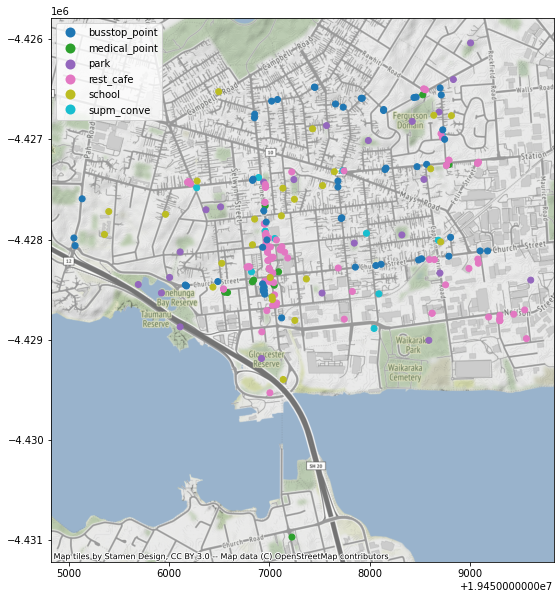

In [3]:
ax = df.to_crs(epsg=3857).plot(column='category', categorical=True, legend=True)
cx.add_basemap(ax)

In [4]:
# Distance calculation
for c in df.category.unique():
    points_in_category = df[df.category == c]
    # sindex.nearest will return the closest point within this category for each element in df.geometry
    indices, distances = points_in_category.sindex.nearest(df.geometry, return_distance=True)
    df[f"nearest_{c}"] = points_in_category.index[indices[1]]
    df[f"nearest_{c}_distance_m"] = distances
df[df.columns[df.columns.str.startswith("nearest")]]

,nearest_park,nearest_park_distance_m,nearest_medical_point,nearest_medical_point_distance_m,nearest_supm_conve,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m
0,0,0.000000,36,590.025525,44,496.858283,88,211.290628,197,360.558330,218,240.441996
1,1,0.000000,31,860.403844,41,261.268927,126,104.075998,153,151.234066,220,247.500057
2,2,0.000000,27,188.876672,48,180.339191,132,173.100288,167,137.103061,204,48.805781
3,3,0.000000,32,386.003804,44,400.332350,91,237.351935,147,336.527784,208,168.054720
4,4,0.000000,32,645.892148,46,124.991587,91,235.795972,147,190.992889,208,476.945562
...,...,...,...,...,...,...,...,...,...,...,...,...
219,8,320.710845,24,778.714386,47,326.137857,56,309.515961,182,583.467296,219,0.000000
220,1,247.500057,31,613.196811,41,23.383489,127,149.331308,198,87.040715,220,0.000000
221,5,804.469904,28,979.367432,45,752.951594,57,753.090981,179,338.401875,221,0.000000
222,15,625.817057,24,1125.738461,47,726.775427,56,670.716967,195,235.472247,222,0.000000


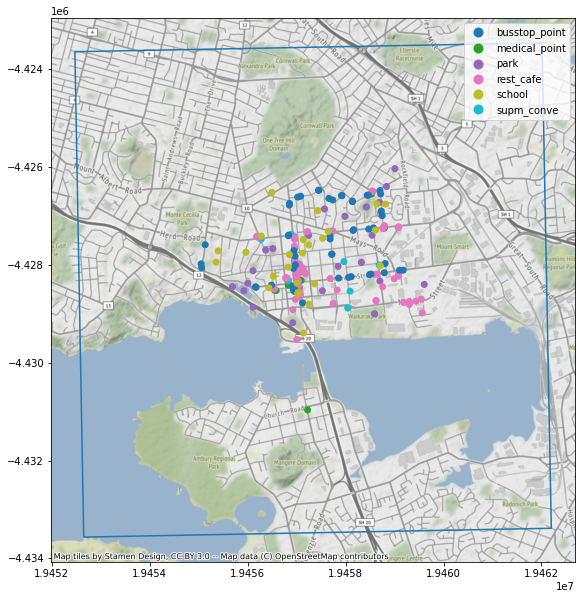

In [5]:
# Calculate Area of Interest (AOI). This is the bounds of the dataset, plus a 2KM buffer
AOI = df.dissolve().buffer(2000).envelope
ax = AOI.to_crs(epsg=3857).boundary.plot()
df.to_crs(epsg=3857).plot(ax=ax, column='category', categorical=True, legend=True)
cx.add_basemap(ax)

In [6]:
# Adapted from https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
network_type = "walk"
trip_time = 15  # in minutes
travel_speed = 4.5  # walking speed in km/hour

# download the street network
G = ox.graph_from_polygon(AOI.to_crs(4326)[0], network_type=network_type)
# project the graph to 2193 CRS (units in meters)
G = ox.project_graph(G, 2193)
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [7]:
def get_isochrone_polygon(point):
    x, y = point.coords[0]
    # Get the closest node to the given point
    center_node = ox.distance.nearest_nodes(G, x, y)
    # Filter the street network to just the nodes accessible within trip_time minutes
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # Get just the x,y points from the subgraph
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    # Take the convex_hull polygon
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    return bounding_poly

df["isochrone_polygon"] = df.geometry.progress_apply(get_isochrone_polygon)

  0%|          | 0/224 [00:00<?, ?it/s]

In [8]:
# Take the first row as a sample, to plot isochrone results
sample = df.loc[0:0]
sample

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,...,nearest_medical_point_distance_m,nearest_supm_conve,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m,isochrone_polygon
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,...,590.025525,44,496.858283,88,211.290628,197,360.55833,218,240.441996,"POLYGON ((1758811.367 5911217.760, 1758788.174..."


In [9]:
# get one color for each category
colors = ox.plot.get_colors(n=len(df.category.unique()), cmap="plasma", start=0, return_hex=True)
print(colors)

['#0d0887', '#6a00a8', '#b12a90', '#e16462', '#fca636', '#f0f921']


0    571227.855623
dtype: float64


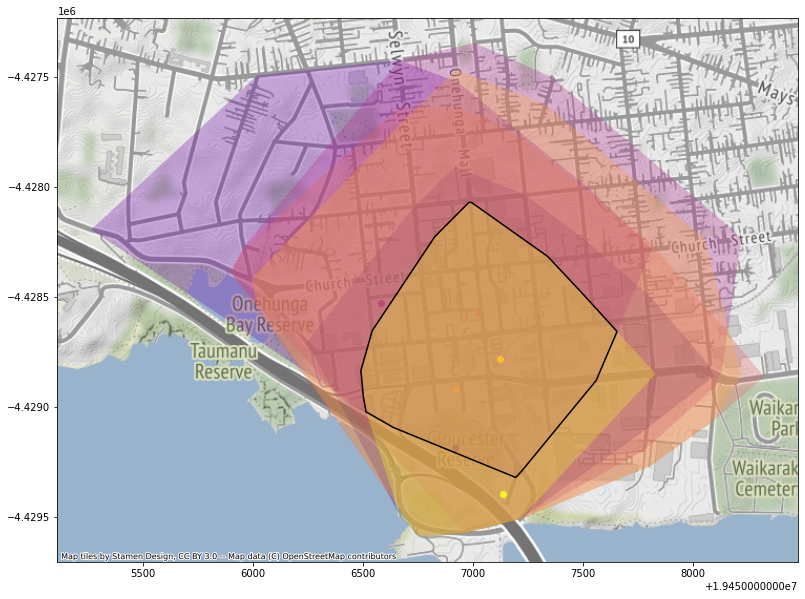

In [10]:
ax = plt.axes()
poly = sample.isochrone_polygon
for i, c in enumerate(df.category.unique()):
    color = colors[i]
    other = df.loc[sample[f"nearest_{c}"]]
    other.to_crs(epsg=3857).plot(ax=ax, color=color)
    other.isochrone_polygon.to_crs(epsg=3857).plot(ax=ax, alpha=.3, color=color)
    poly = poly.intersection(other.isochrone_polygon.iloc[0])
print(poly.area)
poly.boundary.to_crs(epsg=3857).plot(ax=ax, color="black")
cx.add_basemap(ax, zoom=15)

In [11]:
def get_isochrone_intersection(row):
    poly = row.isochrone_polygon
    for c in df.category.unique():
        other = df.loc[row[f"nearest_{c}"]]
        poly = poly.intersection(other.isochrone_polygon)
    return poly

df["isochrone_intersection"] = df.progress_apply(get_isochrone_intersection, axis=1)
df["isochrone_intersection"]

  0%|          | 0/224 [00:00<?, ?it/s]

0      POLYGON ((1759449.471 5911773.983, 1759174.232...
1      POLYGON ((1760331.678 5912149.709, 1760166.497...
2      POLYGON ((1760062.601 5914068.478, 1760448.597...
3      POLYGON ((1759239.741 5912908.320, 1759308.367...
4      POLYGON ((1759621.735 5911664.327, 1759027.820...
                             ...                        
219    POLYGON ((1758669.914 5911913.899, 1758641.953...
220    POLYGON ((1760681.718 5913082.330, 1761117.068...
221    POLYGON ((1758906.079 5913524.269, 1759246.207...
222    POLYGON ((1757725.000 5912356.377, 1757844.681...
223    POLYGON ((1760062.601 5914068.478, 1760448.597...
Name: isochrone_intersection, Length: 224, dtype: geometry

In [12]:
df["isochrone_intersection_area"] = df.isochrone_intersection.area
df

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,...,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m,isochrone_polygon,isochrone_intersection,isochrone_intersection_area
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,...,496.858283,88,211.290628,197,360.558330,218,240.441996,"POLYGON ((1758811.367 5911217.760, 1758788.174...","POLYGON ((1759449.471 5911773.983, 1759174.232...",5.712279e+05
1,1.0,-36.922669,174.800483,Captain Springs Reserve,ChIJ9a8JjstIDW0RHfIbxw4LzxM,POINT (1760369.380 5912192.154),park,NaN,NaN,NaN,...,261.268927,126,104.075998,153,151.234066,220,247.500057,"POLYGON ((1760457.809 5911343.637, 1759945.179...","POLYGON ((1760331.678 5912149.709, 1760166.497...",7.849402e+05
2,3.0,-36.911138,174.800399,Oranga Plunket Clinic,ChIJRdAHp8ZIDW0RvEv6agNJR4E,POINT (1760386.025 5913471.627),park,NaN,NaN,NaN,...,180.339191,132,173.100288,167,137.103061,204,48.805781,"POLYGON ((1760328.510 5912520.952, 1759997.805...","POLYGON ((1760062.601 5914068.478, 1760448.597...",1.440166e+06
3,4.0,-36.924106,174.789916,Rowe Reserve East,ChIJ-frCEAJJDW0RM_Urv0pjHvE,POINT (1759425.142 5912050.503),park,NaN,NaN,NaN,...,400.332350,91,237.351935,147,336.527784,208,168.054720,"POLYGON ((1759513.030 5911354.282, 1759129.299...","POLYGON ((1759239.741 5912908.320, 1759308.367...",1.148364e+06
4,5.0,-36.920526,174.792803,Buch Park,ChIJhYjfdLZIDW0RdOS3nEfuzbg,POINT (1759689.719 5912442.763),park,NaN,NaN,NaN,...,124.991587,91,235.795972,147,190.992889,208,476.945562,"POLYGON ((1759618.566 5911516.625, 1758959.448...","POLYGON ((1759621.735 5911664.327, 1759027.820...",9.932791e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,32.0,-36.918464,174.775892,Robert Howell Teacher Of Singing Piano And Violin,ChIJ8zT2DKlIDW0RqZ5MGkB41io,POINT (1758187.572 5912699.763),school,NaN,NaN,NaN,...,326.137857,56,309.515961,182,583.467296,219,0.000000,"POLYGON ((1758504.788 5911760.971, 1757423.252...","POLYGON ((1758669.914 5911913.899, 1758641.953...",9.219668e+05
220,33.0,-36.920439,174.800548,Youth Skills Nz Ltd,ChIJhxXXvM5IDW0RGPqkwj4Zc_A,POINT (1760379.860 5912439.432),school,NaN,NaN,NaN,...,23.383489,127,149.331308,198,87.040715,220,0.000000,"POLYGON ((1760391.504 5911405.644, 1759642.047...","POLYGON ((1760681.718 5913082.330, 1761117.068...",9.490391e+05
221,36.0,-36.909680,174.780656,Alexander Technique Auckland - Jann McMichael,ChIJW_dPiKNIDW0RAWDnHQc12Fs,POINT (1758630.188 5913666.441),school,NaN,NaN,NaN,...,752.951594,57,753.090981,179,338.401875,221,0.000000,"POLYGON ((1758973.125 5912768.424, 1758471.679...","POLYGON ((1758906.079 5913524.269, 1759246.207...",6.784119e+05
222,37.0,-36.918265,174.770806,Onehunga High School English Language School,ChIJaY-HRQJGDW0RQO2XIwz5phQ,POINT (1757734.906 5912730.267),school,NaN,NaN,NaN,...,726.775427,56,670.716967,195,235.472247,222,0.000000,"POLYGON ((1758309.646 5912038.468, 1757338.396...","POLYGON ((1757725.000 5912356.377, 1757844.681...",2.102864e+03


In [13]:
# to_file will object to there being multiple geometry columns, so convert isochrone_polygon and isochrone_intersection to WKT
if isinstance(df.isochrone_polygon, gpd.GeoSeries):
    df.isochrone_polygon = df.isochrone_polygon.to_wkt()
    df.isochrone_intersection = df.isochrone_intersection.to_wkt()
df.to_file("pois.gpkg", driver="GPKG")